# Procesos de reversión a la media

In [1]:
import numpy as np
from random import random
from matplotlib import pyplot as plt
import pandas as pd
import warnings
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors

warnings.simplefilter('ignore')
%matplotlib inline

## Con ruido aditivo
* Ecuación diferencial
$$dX_T = \alpha (\mu X_t)dt + \sigma dB_t$$
Donde $\alpha, \sigma \in \mathbb{R}^+$ y $\mu \in \mathbb{R}$

* Solución explícita: $X_t = m + (X_0 - m)e^{-\alpha t} + \sigma e^{-\alpha t}\int_0^t e^{\alpha s}dB_s$

* Solución exacta discretizada:
$X_{t_i} = m + (X_{t_i - 1} - m)e^{\alpha \Delta t_i} + \sigma e^{-\alpha t_i} \in_{t_i - 1}^{t_i} e^{\alpha s}dB_s$

In [23]:
N = 200
dt = 1/252
alfa = 5
mu = 10
sg = 20
k = 1
np.random.seed(1)

* Esquema de Euler: $X_{t_i} = X_{t_i - 1} + \alpha(\mu - X_{t_i - 1})\Delta t_i + \sigma \Delta B_i$

In [24]:
X = np.zeros((k,N))
X[:, 0] = 9.8
for i in range(k):
    for j in range(1,N):
        X[i,j] = X[i, j-1] + alfa*(mu - X[i,j-1])*dt + sg*np.sqrt(dt)*np.random.normal()    

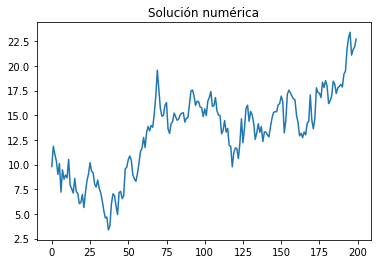

In [25]:
for i in range(k):
    plt.plot(X[i,:])
plt.title('Solución numérica')
plt.show()

Vemos que los parámetros $\sigma$ y $\alpha$ tienen efectos sobre la solución:
* $\alpha$ es inversamente proporcional al tiempo que tarda el proceso en volver a la media, $\mu$.
* $\sigma$ determina la escala del proceso, el efecto de la perturbación.

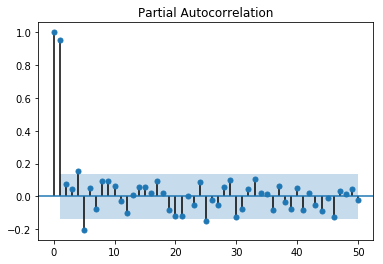

In [26]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(X[0,:], lags = 50)
plt.show()

In [27]:
D = np.zeros((k,N))
R = np.zeros((k,N))
for i in range(k):
    for j in range(1,N):
        D[i,j-1] = X[i,j] - X[i, j-1] 
        R[i,j-1] = (X[i,j] - X[i, j-1])/X[i, j-1]

Veamos la diferencia y los retornos instantáneos del proceso

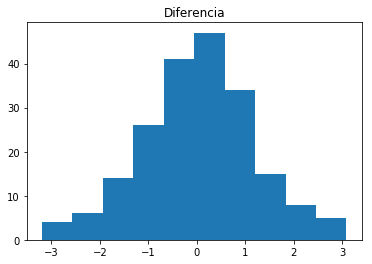

In [28]:
plt.hist(D[0,:])
plt.title('Diferencia')
plt.show()

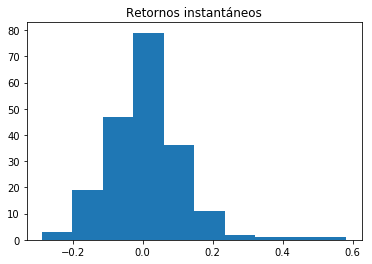

In [8]:
plt.hist(R[0,:])
plt.title('Retornos instantáneos')
plt.show()

In [30]:
from scipy import stats
jb = stats.jarque_bera(D)
jb[1]

0.8167089830557057

In [10]:
def hurst(signal):
    tau = []; lagvec = []

    #  Step through the different lags
    for lag in range(2,20):

    #  produce price difference with lag
        pp = np.subtract(signal[lag:],signal[:-lag])

    #  Write the different lags into a vector
        lagvec.append(lag)

    #  Calculate the variance of the difference vector
        tau.append(np.std(pp))

    #  linear fit to double-log graph (gives power)
    m = np.polyfit(np.log10(lagvec),np.log10(tau),1)

    # calculate hurst
    hurst = m[0]

    return hurst

In [11]:
def hFD(a, k_max): #Higuchi FD

    L = []
    x = []
    N = len(a)

    for k in range(1,k_max):
        Lk = 0
        for m in range(0,k):
            #we pregenerate all idxs
            idxs = np.arange(1,int(np.floor((N-m)/k)),dtype=np.int32)
            Lmk = np.sum(np.abs(a[m+idxs*k] - a[m+k*(idxs-1)]))
            Lmk = (Lmk*(N - 1)/(((N - m)/ k)* k)) / k
            Lk += Lmk

        L.append(np.log(Lk/(m+1)))
        x.append([np.log(1.0/ k), 1])

    (p, r1, r2, s)=np.linalg.lstsq(x, L)
    return p[0]

In [20]:
hFD(X[0,:], 7)

1.941151303070278

In [13]:
hurst(X[0,:])

0.33392252439487663

## Con ruido proporcional
$$dX_t = \alpha(\mu - X_t)dt + \sigma X_t dB_t$$

In [13]:
N = 200
dt = 1/252
alfa = 20
mu = 10
sg = 0.02
k = 1
np.random.seed(1)

In [14]:
X = np.zeros((k,N))
X[:, 0] = 9.8
for i in range(k):
    for j in range(1,N):
        X[i,j] = X[i, j-1] + alfa*(mu - X[i,j-1])*dt + sg*X[i, j-1]*np.sqrt(dt)*np.random.normal()

In [15]:
D = np.zeros((k,N))
R = np.zeros((k,N))
for i in range(k):
    for j in range(1,N):
        D[i,j-1] = X[i,j] - X[i, j-1] 
        R[i,j-1] = (X[i,j] - X[i, j-1])/X[i, j-1]

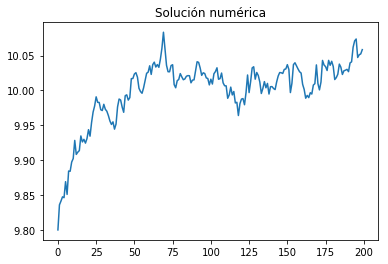

In [16]:
for i in range(k):
    plt.plot(X[i,:])
plt.title('Solución numérica')
plt.show()

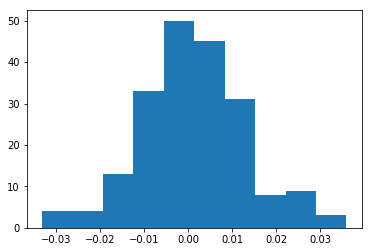

In [17]:
plt.hist(D[0,:])
plt.show()

In [22]:
jb = stats.jarque_bera(D)
lilie = lilliefors(D)
shapiro = stats.shapiro(D)
df = pd.DataFrame()
df['Jarque Bera'] = [1 if jb[1]<0.07 else 0]
df['Shapiro Wilks'] = [1 if shapiro[1]<0.07 else 0]
df['Lilliefors'] = [1 if lilie[1]<0.05 else 0]
df

,Jarque Bera,Shapiro Wilks,Lilliefors
0,0,0,1


### Test de reversión a la media
Exponente de Hurst: si H < 0.5, el proceso es un proceso de reversión a la media

## Con tendencia funcional
$$dX_t = \alpha(\mu(t) - X_t)dt + \sigma X_t^ndB_t$$

* Esquema numérico de Euler
$$X_{t_i} = X_{t_{i-1}} + \alpha(\mu(t_{i-1})-X_{t_{i-1}})\Delta t_i + \sigma X_{t_{i-1}}^n \Delta B_i$$

In [100]:
N = 400
dt = 1/250
alfa = 50
A1 = 0.6 # condicion inicial
A2 = -0.3
sigma = 3.5
k = 1
K1 = 1.8
K2 = 0.8

In [101]:
X = np.zeros((k,N))
X[0,:] = A+0.05
mu = np.zeros(N)

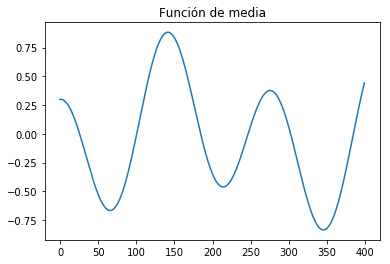

In [102]:
for j in range(N):
    mu[j] = A1*np.cos(2*np.pi*K1*(j-1)*dt) + A2*np.cos(2*np.pi*K2*(j-1)*dt)
plt.plot(mu)
plt.title('Función de media')
plt.show()

In [103]:
for i in range(k):
    for j in range(1,N):
        X[i,j] = X[i,j-1]+alfa*(mu[j-1]-X[i,j-1])*dt + sigma*X[i,j-1]*np.sqrt(dt)*np.random.normal()

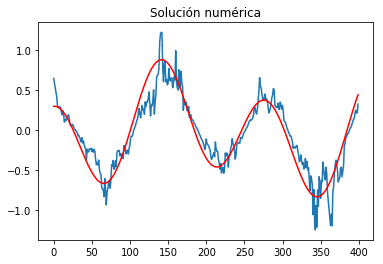

In [104]:
for i in range(k):
    plt.plot(X[i,:])
plt.plot(mu, 'red')
plt.title('Solución numérica')
plt.show()